## Proyecto 7: predicción del rango de instalaciones a partir de variables de las apps.

Contexto y Caso de Uso:  
El product owner de un portafolio de apps debe evaluar si mantiene, incrementa o elimina la inversión en marketing de una app, utilizando datos en tiempo real sobre comportamiento de usuarios, ratings, categoría, tipo de app y características funcionales.

El sistema desarrollado es un modelo predictivo híbrido basado en Machine Learning que permite:

1) Predecir el número esperado de instalaciones (modelo de regresión).
2) Predecir el nivel de adopción de mercado de la app (modelo de clasificación), utilizando segmentación aprendida automáticamente mediante algoritmos no supervisados.

De esta forma, el modelo permite tanto una predicción cuantitativa del crecimiento como una segmentación estratégica de adopción del mercado, para facilitar y orientar la toma de decisiones.


###  1.- Importación de Librerías 

In [293]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import os
os.makedirs("../reports", exist_ok=True)
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.feature_extraction.text import TfidfVectorizer



### 2.- Carga de Datos

In [219]:
#Cargamos la data
df = pd.read_csv("../data/raw/googleplaystore.csv")
print("Dimensiones:", df.shape)
df.head()

Dimensiones: (10841, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [220]:
#Guardamos respaldo de la data cruta
df_raw = df.copy()


In [221]:
#Cambioamos el nombre de las columnas para hacerlos más familiares
df = df.rename(columns={
    "App": "nombre_app",
    "Category": "categoria_app",
    "Rating": "rating_app",
    "Reviews": "cantidad_reviews",
    "Size": "tamano_app",
    "Installs": "instalaciones",
    "Type": "tipo_app",
    "Price": "precio_app",
    "Content Rating": "clasificacion_edad",
    "Genres": "generos_app",
    "Last Updated": "ultima_actualizacion",
    "Current Ver": "version_actual",
    "Android Ver": "version_android"
})

df.head()


,nombre_app,categoria_app,rating_app,cantidad_reviews,tamano_app,instalaciones,tipo_app,precio_app,clasificacion_edad,generos_app,ultima_actualizacion,version_actual,version_android
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


### 3.- EDA

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   nombre_app            10841 non-null  object 
 1   categoria_app         10841 non-null  object 
 2   rating_app            9367 non-null   float64
 3   cantidad_reviews      10841 non-null  object 
 4   tamano_app            10841 non-null  object 
 5   instalaciones         10841 non-null  object 
 6   tipo_app              10840 non-null  object 
 7   precio_app            10841 non-null  object 
 8   clasificacion_edad    10840 non-null  object 
 9   generos_app           10841 non-null  object 
 10  ultima_actualizacion  10841 non-null  object 
 11  version_actual        10833 non-null  object 
 12  version_android       10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [223]:
#Consejo de compañero EH. Usamos esta librería para generar un reporte automático de la data para visualización html
profile = ProfileReport(df, title="Análisis del Perfil de Apps en Google Play Store", explorative=True)

profile.to_file("../reports/google_play_store_profile_reporte.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 124.57it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [224]:
#Revisión de Completitud de Datos
tabla_nulos = pd.DataFrame({
    "nulos": df.isnull().sum(),
    "porcentaje_nulos": (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values("porcentaje_nulos", ascending=False)

tabla_nulos


,nulos,porcentaje_nulos
rating_app,1474,13.60
version_actual,8,0.07
version_android,3,0.03
clasificacion_edad,1,0.01
tipo_app,1,0.01
tamano_app,0,0.00
cantidad_reviews,0,0.00
categoria_app,0,0.00
nombre_app,0,0.00
precio_app,0,0.00


In [225]:
#Revisamos con detalle todas las variables
df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
nombre_app,10841,9660,ROBLOX,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
categoria_app,10841,34,FAMILY,1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating_app,9367.0,NaN,NaN,NaN,4.193338,0.537431,1.0,4.0,4.3,4.5,19.0
cantidad_reviews,10841,6002,0,596,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tamano_app,10841,462,Varies with device,1695,NaN,NaN,NaN,NaN,NaN,NaN,NaN
instalaciones,10841,22,"1,000,000+",1579,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tipo_app,10840,3,Free,10039,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precio_app,10841,93,0,10040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clasificacion_edad,10840,6,Everyone,8714,NaN,NaN,NaN,NaN,NaN,NaN,NaN
generos_app,10841,120,Tools,842,NaN,NaN,NaN,NaN,NaN,NaN,NaN


En el EDA podemos identificar lo siguiente:

5 variables categóricas: categoria_app, tipo_app, clasificacion_edad, generos_app y version_android
1 variable numérica: rating_app
7 variables de texto: nombre_app, cantidad_reviews, tamano_app, instalaciones. precio_app, ultima_actualización

hay 5 variables con valores nulos, 4 de ellas con menos de 10 valores nulos, mientras que que Rating_app tienen 1474. Posteriormente trataremos esa data.

La mayoría de las apps tienen un tamaño que "varía según el dispositivo". la variable tamano_app tiene datos que representan números y texto/categoría como "varies with device". Hay que hacer un tratamiento de esos valores para estandarizarlos.

El dataset tiene mayor cantidad de reviews de apps con categoría "Familiy".

La app Roblox aparece 9 veces en el dataset, validar si son duplicados.

la variable rating_app tiene datos con valor >= 5, lo cual parece ser errores, dado que la escala de rating es de 1 a 5. Hay que eliminar o tratar esa data que está por encima de 5.

Hay al menos 596 apps sin revies (o con cantidad_reviews igual a cero). 

La mayoría de las apps son gratuitas.

Hay 120 géneros de apps clasificados y 6 clasificaciones por edad.


### Limpieza y Conversión a variables numéricas

In [226]:
#Revisamos los valores y clases de las variables string
for col in df.select_dtypes(include="object").columns:
    print(f"\nColumna: {col}")
    print(df[col].value_counts(dropna=False))


Columna: nombre_app
nombre_app
ROBLOX                                               9
CBS Sports App - Scores, News, Stats & Watch Live    8
Duolingo: Learn Languages Free                       7
Candy Crush Saga                                     7
8 Ball Pool                                          7
                                                    ..
Fr. Daoud Lamei                                      1
Poop FR                                              1
PLMGSS FR                                            1
List iptv FR                                         1
Kids Paint Free - Drawing Fun                        1
Name: count, Length: 9660, dtype: int64

Columna: categoria_app
categoria_app
FAMILY                 1972
GAME                   1144
TOOLS                   843
MEDICAL                 463
BUSINESS                460
PRODUCTIVITY            424
PERSONALIZATION         392
COMMUNICATION           387
SPORTS                  384
LIFESTYLE               382
FINAN

In [227]:
# cantidad_reviews → numérico directo
df["cantidad_reviews"] = pd.to_numeric(df["cantidad_reviews"], errors="coerce")

print("Nulos en cantidad_reviews:", df["cantidad_reviews"].isna().sum())

# Precio_app: Normalización y conversión a numérico
#limpieza o normalización
df["precio_app"] = df["precio_app"].astype(str)

df["precio_app"] = (
    df["precio_app"]
    .str.replace("$", "", regex=False)
    .str.replace("Free", "0", regex=False)
    .str.replace(",", "", regex=False)
    .str.strip()
)

# Conversión a numérico
df["precio_app"] = pd.to_numeric(df["precio_app"], errors="coerce")

print("Nulos en precio_app:", df["precio_app"].isna().sum())


#Instalaciones: estandarización y conversión a numérico
df["instalaciones"] = df["instalaciones"].astype(str)

df["instalaciones"] = (
    df["instalaciones"]
    .str.replace(",", "", regex=False)
    .str.replace("+", "", regex=False)
    .str.strip()
)

df["instalaciones_num"] = pd.to_numeric(df["instalaciones"], errors="coerce")

print("Nulos en instalaciones_num:", df["instalaciones_num"].isna().sum())


#tamano_app a numérico (aquí debenos manejar las unidades M y K, así como el valor "varies with device")
df["tamano_app"] = df["tamano_app"].astype(str)

def convertir_tamano(valor):
    valor = valor.strip()
    
    if valor == "Varies with device":
        return np.nan
    
    if valor.endswith("M"):
        return float(valor.replace("M", ""))  # MB
    
    if valor.endswith("k"):
        return float(valor.replace("k", "")) / 1024  # KB → MB
    
    try:
        return float(valor)
    except:
        return np.nan

df["tamano_mb"] = df["tamano_app"].apply(convertir_tamano)

print("Nulos en tamano_mb:", df["tamano_mb"].isna().sum())



Nulos en cantidad_reviews: 1
Nulos en precio_app: 1
Nulos en instalaciones_num: 1
Nulos en tamano_mb: 1696


In [228]:
df[[
    "cantidad_reviews",
    "precio_app",
    "instalaciones_num",
    "tamano_mb"
]].describe()


,cantidad_reviews,precio_app,instalaciones_num,tamano_mb
count,1.084000e+04,10840.000000,1.084000e+04,9145.000000
mean,4.441529e+05,1.027368,1.546434e+07,21.516165
std,2.927761e+06,15.949703,8.502936e+07,22.589084
min,0.000000e+00,0.000000,0.000000e+00,0.008301
25%,3.800000e+01,0.000000,1.000000e+03,4.900000
50%,2.094000e+03,0.000000,1.000000e+05,13.000000
75%,5.477550e+04,0.000000,5.000000e+06,30.000000
max,7.815831e+07,400.000000,1.000000e+09,100.000000


In [229]:
#Eliminamos las filas que tienen <10 valores nulos  
df = df.dropna(subset=["cantidad_reviews", "precio_app", "instalaciones_num", "tipo_app", "clasificacion_edad", "version_actual", "version_android"])

print("Dimensiones después de limpieza:", df.shape)

Dimensiones después de limpieza: (10829, 15)


In [230]:
#Revisión de Completitud de Datos
print("Dimensiones:", df.shape)
tabla_nulos = pd.DataFrame({
    "nulos": df.isnull().sum(),
    "porcentaje_nulos": (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values("porcentaje_nulos", ascending=False)

tabla_nulos

Dimensiones: (10829, 15)


,nulos,porcentaje_nulos
tamano_mb,1694,15.64
rating_app,1469,13.57
nombre_app,0,0.00
cantidad_reviews,0,0.00
tamano_app,0,0.00
instalaciones,0,0.00
categoria_app,0,0.00
tipo_app,0,0.00
precio_app,0,0.00
generos_app,0,0.00


Hay 1469 valores nulos en la variable rating_app y 1694 en tamano_mb, haremos la imputación de esos valores.

Procederemos a hacer la imputación de los valores nulos de la variable rating_app. Para eso, haremos un análisis de la distribución de la variable.

In [231]:
# Estadística descriptiva de variables a imputar
df[["rating_app", "tamano_mb"]].describe()


,rating_app,tamano_mb
count,9360.000000,9135.000000
mean,4.191838,21.534596
std,0.515263,22.593997
min,1.000000,0.008301
25%,4.000000,4.900000
50%,4.300000,13.000000
75%,4.500000,30.000000
max,5.000000,100.000000


In [232]:
#Determinación de la simetría de los datos
print("\nSkewness rating_app:", df["rating_app"].skew())

if df["rating_app"].skew() < -0.5:
    print("  → Distribución sesgada a la IZQUIERDA (cola larga hacia valores bajos)")
elif df["rating_app"].skew() > 0.5:
    print("  → Distribución sesgada a la DERECHA (cola larga hacia valores altos)")
else:
    print("  → Distribución aproximadamente SIMÉTRICA")

print("Skewness tamano_mb:", df["tamano_mb"].skew())
if df["tamano_mb"].skew() < -0.5:
    print("  → Distribución sesgada a la IZQUIERDA (cola larga hacia valores bajos)")
elif df["tamano_mb"].skew() > 0.5:
    print("  → Distribución sesgada a la DERECHA (cola larga hacia valores altos)")
else:
    print("  → Distribución aproximadamente SIMÉTRICA")


Skewness rating_app: -1.8501346146929738
  → Distribución sesgada a la IZQUIERDA (cola larga hacia valores bajos)
Skewness tamano_mb: 1.5561161734008082
  → Distribución sesgada a la DERECHA (cola larga hacia valores altos)


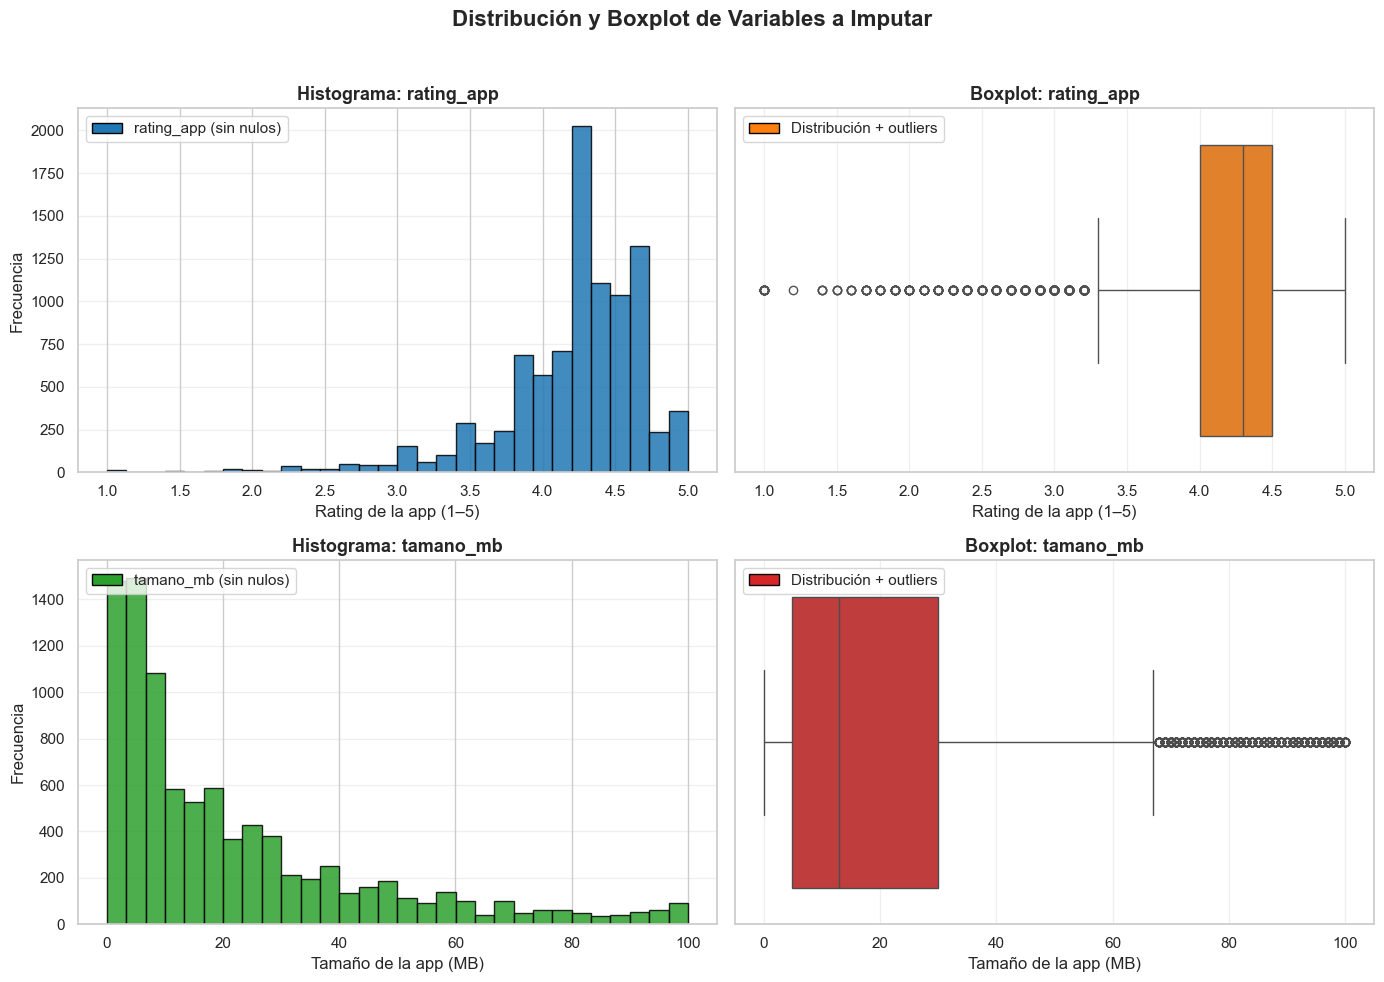

In [233]:
#Visualización gráfica de las variables a imputar
from matplotlib.patches import Patch

sns.set_theme(style="whitegrid")

variables_a_imputar = [
    ("rating_app", "Rating de la app (1–5)", "#1f77b4", "#ff7f0e"),
    ("tamano_mb", "Tamaño de la app (MB)", "#2ca02c", "#d62728")
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), gridspec_kw={"height_ratios": [2, 2]})
fig.suptitle("Distribución y Boxplot de Variables a Imputar", fontsize=16, fontweight="bold")

for i, (col, label_x, color_hist, color_box) in enumerate(variables_a_imputar):
    serie = df[col].dropna()

    # --- Histograma ---
    ax_hist = axes[i, 0]
    ax_hist.hist(serie, bins=30, color=color_hist, edgecolor="black", alpha=0.85)
    ax_hist.set_title(f"Histograma: {col}", fontsize=13, fontweight="bold")
    ax_hist.set_xlabel(label_x)
    ax_hist.set_ylabel("Frecuencia")
    ax_hist.grid(axis="y", alpha=0.3)

    # Leyenda 
    ax_hist.legend(handles=[
        Patch(facecolor=color_hist, edgecolor="black", label=f"{col} (sin nulos)")
    ], loc="upper left")

    # --- Boxplot ---
    ax_box = axes[i, 1]
    sns.boxplot(x=serie, ax=ax_box, color=color_box)
    ax_box.set_title(f"Boxplot: {col}", fontsize=13, fontweight="bold")
    ax_box.set_xlabel(label_x)
    ax_box.grid(axis="x", alpha=0.3)
    ax_box.legend(handles=[
        Patch(facecolor=color_box, edgecolor="black", label="Distribución + outliers")
    ], loc="upper left")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


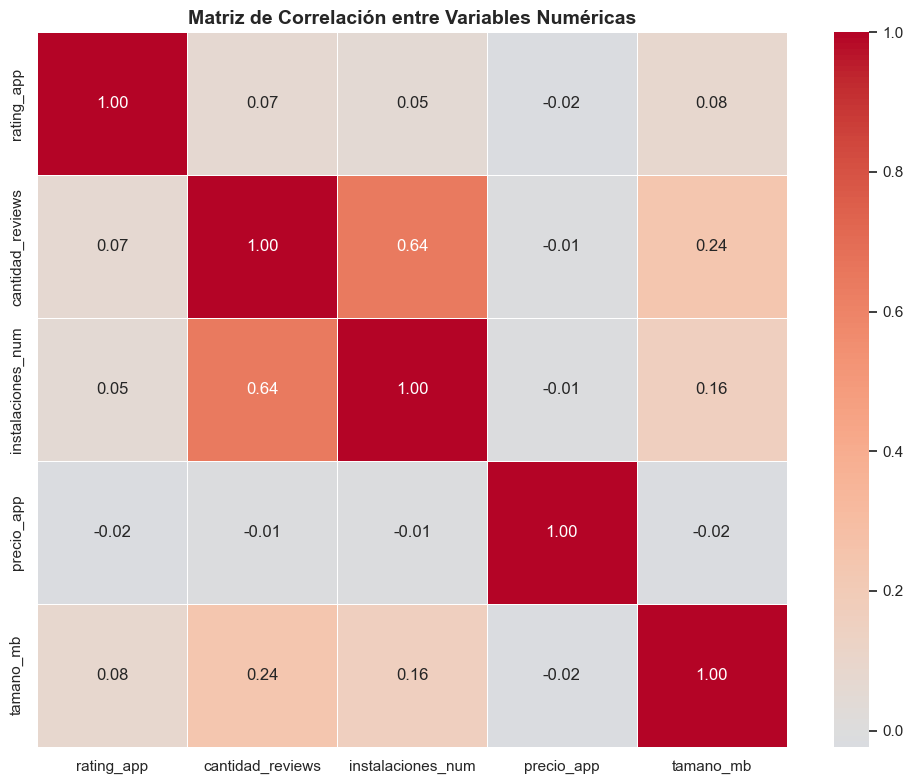

,rating_app,cantidad_reviews,instalaciones_num,precio_app,tamano_mb
rating_app,1.000000,0.068133,0.051337,-0.021919,0.083643
cantidad_reviews,0.068133,1.000000,0.643112,-0.009674,0.238178
instalaciones_num,0.051337,0.643112,1.000000,-0.011698,0.164721
precio_app,-0.021919,-0.009674,-0.011698,1.000000,-0.023058
tamano_mb,0.083643,0.238178,0.164721,-0.023058,1.000000


In [234]:
#Estudiamos correlaciones e influencias entre variables

vars_numericas = [
    "rating_app",
    "cantidad_reviews",
    "instalaciones_num",
    "precio_app",
    "tamano_mb"
]

df_num = df[vars_numericas]

# Matriz de correlación
corr_matrix = df_num.corr(method="pearson")

# Visualización heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor="white"
)
plt.title("Matriz de Correlación entre Variables Numéricas", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


corr_matrix


Dado que las variables tienen distribuciones sesgadas a la izquierda y a la derecha, con muchos outliers, y baja correlación entre ellas y entre otras variables, **imputaremos ambas variables con la mediana.**

Sin embargo, considerando que el rating y el tamaño de la app pueden variar según la categoría a la que pertenece la app, **se calcularán la medianas por categoría y se imputarán ambas variables por categoría.**

In [235]:
#Imputación rating_app usando mediana por categoría
# Mediana por categoría
mediana_por_categoria = df.groupby("categoria_app")["rating_app"].median()

# Imputación solo donde rating_app es nulo
mask_nulos = df["rating_app"].isna()

df.loc[mask_nulos, "rating_app"] = (
    df.loc[mask_nulos, "categoria_app"]
      .map(mediana_por_categoria)
)


In [236]:
#Imputación tamano_app usando mediana por categoría
# Mediana global 
mediana_global_tamano = df["tamano_mb"].median()

# Mediana por categoría
mediana_tamano_categoria = (
    df.groupby("categoria_app")["tamano_mb"].median()
)

#  Imputación solo donde tamano_app es nulo
mask_nulos_tamano = df["tamano_mb"].isna()

df.loc[mask_nulos_tamano, "tamano_mb"] = (
    df.loc[mask_nulos_tamano, "categoria_app"]
      .map(mediana_tamano_categoria)
      .fillna(mediana_global_tamano)
)

In [237]:
#Control visual - revisión de Completitud de Datos
print("Dimensiones:", df.shape)
tabla_nulos = pd.DataFrame({
    "nulos": df.isnull().sum(),
    "porcentaje_nulos": (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values("porcentaje_nulos", ascending=False)

tabla_nulos

Dimensiones: (10829, 15)


,nulos,porcentaje_nulos
nombre_app,0,0.0
categoria_app,0,0.0
rating_app,0,0.0
cantidad_reviews,0,0.0
tamano_app,0,0.0
instalaciones,0,0.0
tipo_app,0,0.0
precio_app,0,0.0
clasificacion_edad,0,0.0
generos_app,0,0.0


### 4.- Variables

Variable Objetivo: instalaciones_num

Variables numéricas: rating_app, cantidad_reviews, precio_app, tamano_mb

Variables categóricas: categoria_app, tipo_app, clasificacion_edad, generos_app, version_android

Dado que inicialmente usaremos Random Forest, no se requiere escalado, pero como además se quiere crear un modelo de Regresión Logística y KNN, aprovechamos de escalar ahora las variables. Usaremos standardScaler para las numéricas y OneHotEncoder para las Categóricas

In [238]:
# Variable objetivo (haremos una clasificación por rangos más adelante)
y = df["instalaciones_num"]

# Variables predictoras 
X = df.drop(columns=["instalaciones", "instalaciones_num"])

numericas = [
    "rating_app",
    "cantidad_reviews",
    "precio_app",
    "tamano_mb"
]

categoricas = [
    "categoria_app",
    "tipo_app",
    "clasificacion_edad",
    "generos_app",
    "version_android"
]


### 5.- Escalado y Codificación

In [239]:
#Escalado de variables numéricas

df_escalado = df.copy()

escalador = StandardScaler()

df_escalado.loc[:, numericas] = escalador.fit_transform(
    df_escalado.loc[:, numericas]
)

df_escalado[numericas].describe().T


,count,mean,std,min,25%,50%,75%,max
rating_app,10829.0,1.627247e-16,1.000046,-6.660213,-0.221584,0.193812,0.609207,1.647696
cantidad_reviews,10829.0,0.000000e+00,1.000046,-0.151789,-0.151776,-0.151072,-0.133075,26.531796
precio_app,10829.0,-5.249184e-18,1.000046,-0.064429,-0.064429,-0.064429,-0.064429,25.002875
tamano_mb,10829.0,-5.249184e-18,1.000046,-0.957352,-0.694029,-0.392643,0.313732,3.751422


In [241]:
#Codificación de variables categóricas

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

X_cat = ohe.fit_transform(df_escalado[categoricas])

nombres_ohe = ohe.get_feature_names_out(categoricas)

X_cat_df = pd.DataFrame(X_cat, columns=nombres_ohe, index=df_escalado.index)

X_cat_df.head()




,categoria_app_ART_AND_DESIGN,categoria_app_AUTO_AND_VEHICLES,categoria_app_BEAUTY,categoria_app_BOOKS_AND_REFERENCE,categoria_app_BUSINESS,categoria_app_COMICS,categoria_app_COMMUNICATION,categoria_app_DATING,categoria_app_EDUCATION,categoria_app_ENTERTAINMENT,categoria_app_EVENTS,categoria_app_FAMILY,categoria_app_FINANCE,categoria_app_FOOD_AND_DRINK,categoria_app_GAME,categoria_app_HEALTH_AND_FITNESS,categoria_app_HOUSE_AND_HOME,categoria_app_LIBRARIES_AND_DEMO,categoria_app_LIFESTYLE,categoria_app_MAPS_AND_NAVIGATION,categoria_app_MEDICAL,categoria_app_NEWS_AND_MAGAZINES,categoria_app_PARENTING,categoria_app_PERSONALIZATION,categoria_app_PHOTOGRAPHY,categoria_app_PRODUCTIVITY,categoria_app_SHOPPING,categoria_app_SOCIAL,categoria_app_SPORTS,categoria_app_TOOLS,categoria_app_TRAVEL_AND_LOCAL,categoria_app_VIDEO_PLAYERS,categoria_app_WEATHER,tipo_app_Free,tipo_app_Paid,clasificacion_edad_Adults only 18+,clasificacion_edad_Everyone,clasificacion_edad_Everyone 10+,clasificacion_edad_Mature 17+,clasificacion_edad_Teen,clasificacion_edad_Unrated,generos_app_Action,generos_app_Action;Action & Adventure,generos_app_Adventure,generos_app_Adventure;Action & Adventure,generos_app_Adventure;Brain Games,generos_app_Adventure;Education,generos_app_Arcade,generos_app_Arcade;Action & Adventure,generos_app_Arcade;Pretend Play,generos_app_Art & Design,generos_app_Art & Design;Action & Adventure,generos_app_Art & Design;Creativity,generos_app_Art & Design;Pretend Play,generos_app_Auto & Vehicles,generos_app_Beauty,generos_app_Board,generos_app_Board;Action & Adventure,generos_app_Board;Brain Games,generos_app_Board;Pretend Play,generos_app_Books & Reference,generos_app_Books & Reference;Creativity,generos_app_Books & Reference;Education,generos_app_Business,generos_app_Card,generos_app_Card;Action & Adventure,generos_app_Card;Brain Games,generos_app_Casino,generos_app_Casual,generos_app_Casual;Action & Adventure,generos_app_Casual;Brain Games,generos_app_Casual;Creativity,generos_app_Casual;Education,generos_app_Casual;Music & Video,generos_app_Casual;Pretend Play,generos_app_Comics,generos_app_Comics;Creativity,generos_app_Communication,generos_app_Communication;Creativity,generos_app_Dating,generos_app_Education,generos_app_Education;Action & Adventure,generos_app_Education;Brain Games,generos_app_Education;Creativity,generos_app_Education;Education,generos_app_Education;Music & Video,generos_app_Education;Pretend Play,generos_app_Educational,generos_app_Educational;Action & Adventure,generos_app_Educational;Brain Games,generos_app_Educational;Creativity,generos_app_Educational;Education,generos_app_Educational;Pretend Play,generos_app_Entertainment,generos_app_Entertainment;Action & Adventure,generos_app_Entertainment;Brain Games,generos_app_Entertainment;Creativity,generos_app_Entertainment;Education,generos_app_Entertainment;Music & Video,generos_app_Entertainment;Pretend Play,generos_app_Events,generos_app_Finance,generos_app_Food & Drink,generos_app_Health & Fitness,generos_app_Health & Fitness;Action & Adventure,generos_app_Health & Fitness;Education,generos_app_House & Home,generos_app_Libraries & Demo,generos_app_Lifestyle,generos_app_Lifestyle;Education,generos_app_Lifestyle;Pretend Play,generos_app_Maps & Navigation,generos_app_Medical,generos_app_Music,generos_app_Music & Audio;Music & Video,generos_app_Music;Music & Video,generos_app_News & Magazines,generos_app_Parenting,generos_app_Parenting;Brain Games,generos_app_Parenting;Education,generos_app_Parenting;Music & Video,generos_app_Personalization,generos_app_Photography,generos_app_Productivity,generos_app_Puzzle,generos_app_Puzzle;Action & Adventure,generos_app_Puzzle;Brain Games,generos_app_Puzzle;Creativity,generos_app_Puzzle;Education,generos_app_Racing,generos_app_Racing;Action & Adventure,generos_app_Racing;Pretend Play,generos_app_Role Playing,generos_app_Role Playing;Action & Adventure,generos_app_Role Playing;Brain Games,generos_app_Role Playing;Education,generos_app

In [243]:
#Unimos las variables numéricas escaladas y las categóricas codificadas

X_final = pd.concat([df_escalado[numericas], X_cat_df], axis=1)

print("Dimensión df_escalado numéricas:", df_escalado[numericas].shape)
print("Dimensión X_cat_df:", X_cat_df.shape)
print("Dimensión X_final:", X_final.shape)

X_final.head()


Dimensión df_escalado numéricas: (10829, 4)
Dimensión X_cat_df: (10829, 193)
Dimensión X_final: (10829, 197)


,rating_app,cantidad_reviews,precio_app,tamano_mb,categoria_app_ART_AND_DESIGN,categoria_app_AUTO_AND_VEHICLES,categoria_app_BEAUTY,categoria_app_BOOKS_AND_REFERENCE,categoria_app_BUSINESS,categoria_app_COMICS,categoria_app_COMMUNICATION,categoria_app_DATING,categoria_app_EDUCATION,categoria_app_ENTERTAINMENT,categoria_app_EVENTS,categoria_app_FAMILY,categoria_app_FINANCE,categoria_app_FOOD_AND_DRINK,categoria_app_GAME,categoria_app_HEALTH_AND_FITNESS,categoria_app_HOUSE_AND_HOME,categoria_app_LIBRARIES_AND_DEMO,categoria_app_LIFESTYLE,categoria_app_MAPS_AND_NAVIGATION,categoria_app_MEDICAL,categoria_app_NEWS_AND_MAGAZINES,categoria_app_PARENTING,categoria_app_PERSONALIZATION,categoria_app_PHOTOGRAPHY,categoria_app_PRODUCTIVITY,categoria_app_SHOPPING,categoria_app_SOCIAL,categoria_app_SPORTS,categoria_app_TOOLS,categoria_app_TRAVEL_AND_LOCAL,categoria_app_VIDEO_PLAYERS,categoria_app_WEATHER,tipo_app_Free,tipo_app_Paid,clasificacion_edad_Adults only 18+,clasificacion_edad_Everyone,clasificacion_edad_Everyone 10+,clasificacion_edad_Mature 17+,clasificacion_edad_Teen,clasificacion_edad_Unrated,generos_app_Action,generos_app_Action;Action & Adventure,generos_app_Adventure,generos_app_Adventure;Action & Adventure,generos_app_Adventure;Brain Games,generos_app_Adventure;Education,generos_app_Arcade,generos_app_Arcade;Action & Adventure,generos_app_Arcade;Pretend Play,generos_app_Art & Design,generos_app_Art & Design;Action & Adventure,generos_app_Art & Design;Creativity,generos_app_Art & Design;Pretend Play,generos_app_Auto & Vehicles,generos_app_Beauty,generos_app_Board,generos_app_Board;Action & Adventure,generos_app_Board;Brain Games,generos_app_Board;Pretend Play,generos_app_Books & Reference,generos_app_Books & Reference;Creativity,generos_app_Books & Reference;Education,generos_app_Business,generos_app_Card,generos_app_Card;Action & Adventure,generos_app_Card;Brain Games,generos_app_Casino,generos_app_Casual,generos_app_Casual;Action & Adventure,generos_app_Casual;Brain Games,generos_app_Casual;Creativity,generos_app_Casual;Education,generos_app_Casual;Music & Video,generos_app_Casual;Pretend Play,generos_app_Comics,generos_app_Comics;Creativity,generos_app_Communication,generos_app_Communication;Creativity,generos_app_Dating,generos_app_Education,generos_app_Education;Action & Adventure,generos_app_Education;Brain Games,generos_app_Education;Creativity,generos_app_Education;Education,generos_app_Education;Music & Video,generos_app_Education;Pretend Play,generos_app_Educational,generos_app_Educational;Action & Adventure,generos_app_Educational;Brain Games,generos_app_Educational;Creativity,generos_app_Educational;Education,generos_app_Educational;Pretend Play,generos_app_Entertainment,generos_app_Entertainment;Action & Adventure,generos_app_Entertainment;Brain Games,generos_app_Entertainment;Creativity,generos_app_Entertainment;Education,generos_app_Entertainment;Music & Video,generos_app_Entertainment;Pretend Play,generos_app_Events,generos_app_Finance,generos_app_Food & Drink,generos_app_Health & Fitness,generos_app_Health & Fitness;Action & Adventure,generos_app_Health & Fitness;Education,generos_app_House & Home,generos_app_Libraries & Demo,generos_app_Lifestyle,generos_app_Lifestyle;Education,generos_app_Lifestyle;Pretend Play,generos_app_Maps & Navigation,generos_app_Medical,generos_app_Music,generos_app_Music & Audio;Music & Video,generos_app_Music;Music & Video,generos_app_News & Magazines,generos_app_Parenting,generos_app_Parenting;Brain Games,generos_app_Parenting;Education,generos_app_Parenting;Music & Video,generos_app_Personalization,generos_app_Photography,generos_app_Productivity,generos_app_Puzzle,generos_app_Puzzle;Action & Adventure,generos_app_Puzzle;Brain Games,generos_app_Puzzle;Creativity,generos_app_Puzzle;Education,generos_app_Racing,generos_app_Racing;Action & Adventure,generos_app_Racing;Pretend Play,generos_app_Role Playing,generos_app_Role Playing;Action & Adventure,generos_app_Role Playing;Brain Gam

In [248]:

# Creamos la variable objetivo instalaciones_rango (con base en valores que he predeterminado considerando la media y cuartiles de la variable instalaciones_num)

df = df.copy()

bins = [
    0,
    12_000,
    250_000,
    5_000_000,
    1_000_000_000
]

labels = ["nicho", "moderado", "popular", "viral"]

df.loc[:, "instalaciones_rango"] = pd.cut(
    df["instalaciones_num"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)
# Verificación básica
df["instalaciones_rango"].value_counts().sort_index()



instalaciones_rango
nicho       4234
moderado    1647
popular     2868
viral       2080
Name: count, dtype: int64

El dataset está desbalanceado, pero no parecieran diferencias muy críticas y refleja muy bien el nefocio porque hay muchas apps de nicho.

class_weight="balanced" será una buena decisión en clasificación

Muy buen realismo de negocio (muchas apps nicho)

In [249]:
#Como realizaremos un modelo de regresión y otro de clasificación, definimos los targets correspondientes

# Target para regresión
y_reg = df["instalaciones_num"]

# Target para clasificación
y_clf = df["instalaciones_rango"]


### 6.- Train/Test Split

In [251]:
#Usaremos el mismo split de datos para ambos modelos, por lo que hacemos un solo train_test_split con ambos targets

X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X_final,
    y_reg,
    y_clf,
    test_size=0.2,
    random_state=42,
    stratify=y_clf   #Mantiene la proporción de clases en train y test
)


In [252]:
print("Train:", X_train.shape)
print("Test:", X_test.shape)

y_clf_train.value_counts(normalize=True)


Train: (8663, 197)
Test: (2166, 197)


instalaciones_rango
nicho       0.390973
popular     0.264804
viral       0.192081
moderado    0.152141
Name: proportion, dtype: float64

### 7.- Modelo 1: Random Forest Regressor

In [254]:
#Entrenamiento del modelo de regresión Random Forest
rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train, y_reg_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [255]:
#Evaluación del modelo de regresión Random Forest

y_reg_pred = rf_reg.predict(X_test)

mae = mean_absolute_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
r2 = r2_score(y_reg_test, y_reg_pred)

print(f"MAE: {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"R²: {r2:.3f}")


MAE: 4,571,421
RMSE: 27,834,566
R²: 0.884


El modelo 1 tiene un desempeño global alto. El R2 = 0.884 indica que el modelo explica ~88% de la variabilidad en el número de instalaciones. El MAE ≈ 4.57 millones de instalaciones es aceptable, dado que el rango va desde miles hasta 1.000 millones. El RMSE resulta elevado por outliers estructurales, RMSE ≈ 27.8 millones refleja que las apps virales (cola larga) impactan fuerte el error. Podríamos considerar tratar esos outliers para comparar resultados.

El modelo es útil para estimaciones continuas de descargas esperadas, y puede ser ideal para: proyecciones de crecimiento y priorizar inversión entre apps similares.

### 8.- Modelo 2: Random Forest Classifier

In [257]:
#Entrenamiento del modelo de clasificación Random Forest

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",  # CLAVE
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_clf_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [258]:
# Evaluación del modelo de clasificación Random Forest


y_clf_pred = rf_clf.predict(X_test)

print(classification_report(y_clf_test, y_clf_pred))


              precision    recall  f1-score   support

    moderado       0.70      0.72      0.71       329
       nicho       0.93      0.94      0.94       847
     popular       0.82      0.85      0.84       574
       viral       0.92      0.84      0.88       416

    accuracy                           0.86      2166
   macro avg       0.84      0.84      0.84      2166
weighted avg       0.87      0.86      0.86      2166



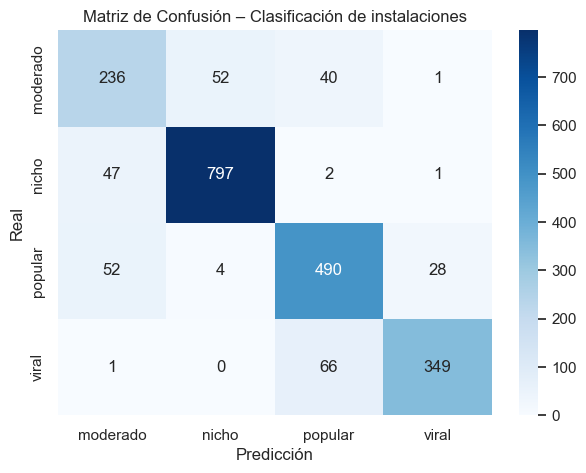

In [259]:
#Matriz de confusión para el modelo de clasificación Random Forest

cm = confusion_matrix(y_clf_test, y_clf_pred, labels=rf_clf.classes_)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=rf_clf.classes_,
            yticklabels=rf_clf.classes_,
            cmap="Blues")

plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión – Clasificación de instalaciones")
plt.show()


El Modelo 2 muestra un muy buen desempeño general, con un Accuracy = 86% y F1-score ponderado de 0.86

Es muy bueno en discriminación de extremos: Clases nicho y viral muestran F1 > 0.88, lo que es clave para decisiones de negocio:

nicho → descartar o testear con bajo presupuesto

viral → escalar inversión

Clase moderado es la más difícil, con un F1 de 0.71, y esto es esperable porque es una clase intermedia con fronteras difusas entre nicho y popular.


Este modelo es ideal para clasificar rápidamente nuevas apps en niveles de impacto, ayuda al Product Owners a decidir mantener, escalar o detener inversión en marketing. Como valor agregado, es más interpretable y accionable para perfiles no técnicos y perfecto para dashboards ejecutivos.

 ### 9.- Tuning + Ensambles

In [260]:
# Definimos columnas y Targets

# Targets
y_reg = df["instalaciones_num"]
y_clf = df["instalaciones_rango"]

# Features: 
X = df.drop(columns=["instalaciones_num", "instalaciones_rango", "instalaciones"])

# Columnas numéricas y categóricas 
num_cols = ["rating_app", "cantidad_reviews", "precio_app", "tamano_mb"]
cat_cols = [c for c in X.columns if c not in num_cols]


In [ ]:
#Preprocesamiento con pipeline
preprocesamiento = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)


In [270]:
#Split para ambos modelos
from sklearn.model_selection import train_test_split

# Regresión
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X_final, y_reg, test_size=0.2, random_state=42
)

# Clasificación
X_train2, X_test2, y_clf_train, y_clf_test = train_test_split(
    X_final, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)


In [274]:
print(X_train2.select_dtypes(include="object").columns)


Index([], dtype='object')


### Tuning del Modelo 2 (clasificación)

In [273]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Pipeline del clasificador
clf_pipe = Pipeline([
    ("model", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Espacio de búsqueda de hiperparámetros
param_dist_clf = {
    "model__n_estimators": [200, 400, 700, 1000],
    "model__max_depth": [None, 10, 20, 30, 50],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5],
    "model__bootstrap": [True, False]
}

search_clf = RandomizedSearchCV(
    clf_pipe,
    param_distributions=param_dist_clf,
    n_iter=20,
    cv=3,
    scoring="f1_weighted",
    random_state=42,
    verbose=2,
    n_jobs=-1
)

search_clf.fit(X_train2, y_clf_train)

best_clf = search_clf.best_estimator_

print("Mejores hiperparámetros (clasificación):")
print(search_clf.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros (clasificación):
{'model__n_estimators': 1000, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 50, 'model__bootstrap': False}


In [280]:
#Evaluación del nuevo modelo

y_pred_clf_tuned = best_clf.predict(X_test2)

print("Accuracy (modelo tuneado):", accuracy_score(y_clf_test, y_pred_clf_tuned))
print("\nReporte de Clasificación (modelo tuneado):\n")
print(classification_report(y_clf_test, y_pred_clf_tuned))



Accuracy (modelo tuneado): 0.8628808864265928

Reporte de Clasificación (modelo tuneado):

              precision    recall  f1-score   support

    moderado       0.74      0.62      0.68       329
       nicho       0.93      0.96      0.95       847
     popular       0.79      0.88      0.83       574
       viral       0.93      0.83      0.88       416

    accuracy                           0.86      2166
   macro avg       0.85      0.82      0.83      2166
weighted avg       0.86      0.86      0.86      2166



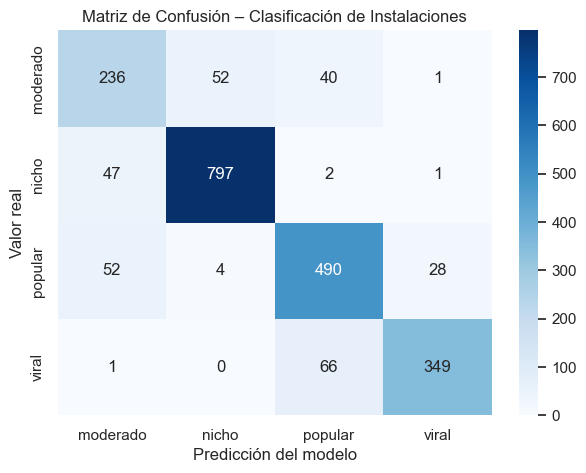

In [286]:
#Matriz de confusión para el modelo de clasificación Random Forest tuneado

cm = confusion_matrix(y_clf_test, y_clf_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=rf_clf.classes_,
            yticklabels=rf_clf.classes_,
            cmap="Blues")

plt.title("Matriz de Confusión – Clasificación de Instalaciones")
plt.xlabel("Predicción del modelo")
plt.ylabel("Valor real")
plt.show()

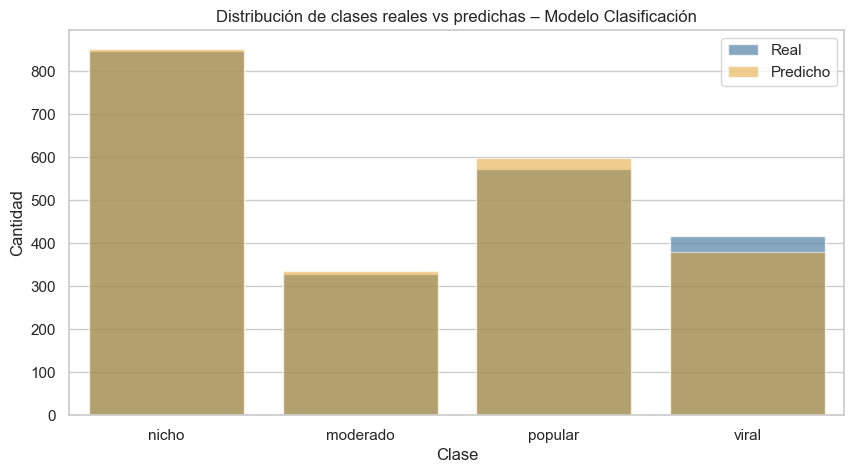

In [285]:
#Comparación visual de clases reales vs predichas – Modelo de clasificación

df_comp = pd.DataFrame({
    "Real": y_clf_test,
    "Predicho": y_clf_pred
})

plt.figure(figsize=(10,5))
sns.countplot(data=df_comp, x="Real", color="steelblue", alpha=0.7, label="Real")
sns.countplot(data=df_comp, x="Predicho", color="orange", alpha=0.5, label="Predicho")

plt.title("Distribución de clases reales vs predichas – Modelo Clasificación")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.legend()
plt.show()


El modelo 2, tras el ajuste de hiperparámetros, mantiene un accuracy global de 86%, muy similar al modelo original, pero muestra mejoras  en la distribución de errores. El modelo tuneado logra una mejor identificación de las clases extremas (“nicho” y “viral”), reduciendo confusiones críticas que son especialmente importantes desde una perspectiva de negocio (evitar clasificar apps nicho como populares o viceversa). 

La matriz de confusión muestra que la mayor fuente de error sigue concentrándose entre las clases “moderado” y “popular”, lo cual es coherente con la cercanía de los rangos definidos. En comparación con el modelo original, el modelo tuneado mejora el equilibrio entre precisión y recall en clases menos representadas, sin sobreajustar ni degradar el desempeño general, lo que lo convierte en una versión más robusta y confiable para escenarios reales, especialmente cuando se prioriza la correcta segmentación estratégica del portafolio de apps.

### Tuning del Modelo 1 (Regresión)

In [288]:
#Pipeline y RandomizedSearchCV para el modelo de regresión Random Forest
rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist_reg = {
    "n_estimators": [200, 400, 700, 1000],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]
}

search_reg = RandomizedSearchCV(
    estimator=rf_reg,
    param_distributions=param_dist_reg,
    n_iter=20,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=2
)

search_reg.fit(X_train, y_reg_train)

best_reg = search_reg.best_estimator_
print("Mejores hiperparámetros (regresión):")
print(search_reg.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros (regresión):
{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}


In [289]:
#Evaluación del nuevo modelo de regresión
y_pred_tuned = best_reg.predict(X_test)

mae_tuned = mean_absolute_error(y_reg_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_reg_test, y_pred_tuned))
r2_tuned = r2_score(y_reg_test, y_pred_tuned)

print("Modelo 1 - Tuneado")
print(f"MAE:  {mae_tuned:,.0f}")
print(f"RMSE: {rmse_tuned:,.0f}")
print(f"R2:   {r2_tuned:.3f}")


Modelo 1 - Tuneado
MAE:  6,101,720
RMSE: 35,322,168
R2:   0.867


El proceso de tuning del modelo de regresión no logró mejorar el desempeño respecto al modelo base. Aunque el modelo tuneado mantiene un R² alto (0,867), este valor es inferior al R² del modelo original, indicando una menor capacidad explicativa. Asimismo, tanto el MAE (≈ 6,1 millones) como el RMSE (≈ 35,3 millones) aumentaron en comparación con el baseline, lo que evidencia un incremento en el error promedio y en los errores grandes. En términos prácticos, el ajuste de hiperparámetros introdujo mayor complejidad sin traducirse en una mejor generalización. Por esta razón, el modelo base se considera más robusto y adecuado para predecir el número de instalaciones, mientras que el tuning no aporta una mejora cuantitativa relevante en desempeño.

Los resultados del Tuning sugieren usar el modelo 1 (sin tuning) y el modelo 2 (con tuning).

### Ensamblaje del Modelo 2

In [ ]:
#Haremos el ensamble (VotingClassifier soft) para Modelo 2

lr = LogisticRegression(max_iter=3000)
rf = RandomForestClassifier(
    n_estimators=400, random_state=42, n_jobs=-1
)
et = ExtraTreesClassifier(
    n_estimators=500, random_state=42, n_jobs=-1
)
gb = GradientBoostingClassifier(random_state=42)

voting_clf = VotingClassifier(
    estimators=[("lr", lr), ("rf", rf), ("et", et), ("gb", gb)],
    voting="soft"
)

# Entrenamos
voting_clf.fit(X_train2, y_clf_train)

# Predecimos
y_clf_pred_ens = voting_clf.predict(X_test2)

# Evaluación rápida (métricas)
print("Accuracy (Ensamble Modelo 2):", round(accuracy_score(y_clf_test, y_clf_pred_ens), 4))
print("\nReporte de clasificación (Ensamble Modelo 2):\n")
print(classification_report(y_clf_test, y_clf_pred_ens))


Accuracy (Ensamble Modelo 2): 0.8666

Reporte de clasificación (Ensamble Modelo 2):

              precision    recall  f1-score   support

    moderado       0.76      0.61      0.68       329
       nicho       0.91      0.96      0.94       847
     popular       0.81      0.89      0.84       574
       viral       0.94      0.85      0.89       416

    accuracy                           0.87      2166
   macro avg       0.85      0.83      0.84      2166
weighted avg       0.87      0.87      0.86      2166



In [297]:
# Definimos modelos base
rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

lr_clf = LogisticRegression(
    max_iter=1000
)

ensamble_clf = VotingClassifier(
    estimators=[
        ("rf", rf_clf),
        ("lr", lr_clf)
    ],
    voting="soft"
)

ensamble_clf.fit(X_train2, y_clf_train)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('rf', ...), ('lr', ...)]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'soft'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1


In [299]:
#Predicciones del modelo ensamblado

y_clf_pred_ensamble = ensamble_clf.predict(X_test2)


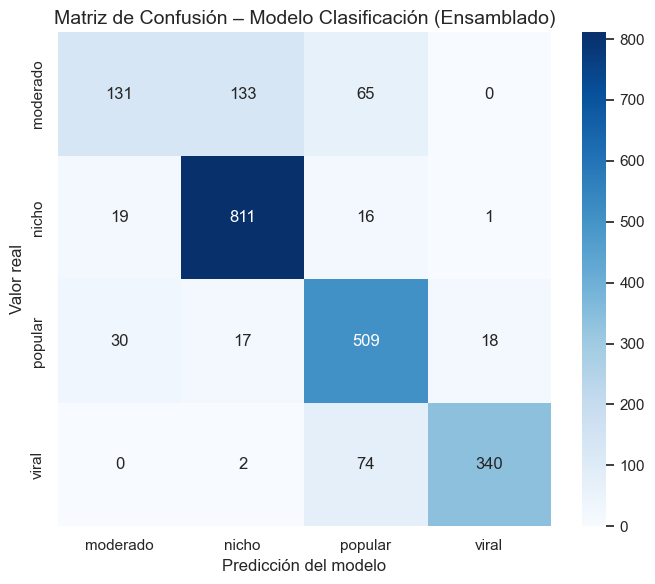

In [300]:
cm = confusion_matrix(y_clf_test, y_clf_pred_ensamble)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0,
    xticklabels=ensamble_clf.classes_,
    yticklabels=ensamble_clf.classes_
)

plt.title("Matriz de Confusión – Modelo Clasificación (Ensamblado)", fontsize=14)
plt.xlabel("Predicción del modelo")
plt.ylabel("Valor real")
plt.tight_layout()
plt.show()


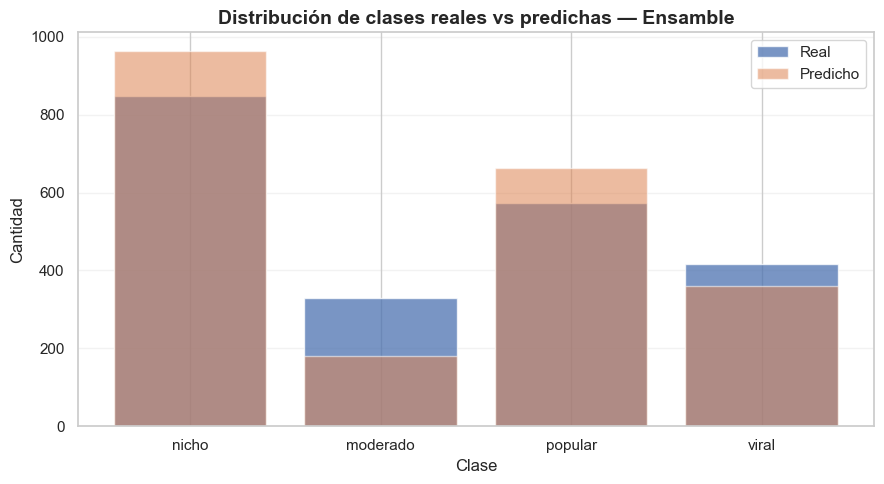

In [303]:
#graficas de comparación de clases reales vs predichas – Modelo ensamblado


clases = ["nicho", "moderado", "popular", "viral"]

# Conteos
conteo_real = np.array([(y_clf_test == c).sum() for c in clases])
conteo_pred = np.array([(y_clf_pred_ensamble == c).sum() for c in clases])

x = np.arange(len(clases))

plt.figure(figsize=(9, 5))

plt.bar(x, conteo_real, 
        label="Real", 
        alpha=0.75)

plt.bar(x, conteo_pred, 
        label="Predicho", 
        alpha=0.55)

plt.xticks(x, clases)
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.title("Distribución de clases reales vs predichas — Ensamble", 
          fontsize=14, fontweight="bold")

plt.legend()
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


### Comparación de modelos de clasificación

Modelo base (Random Forest sin tuning)

- Desempeño sólido desde el inicio, con accuracy ~0.86.

- Muy buen comportamiento en clases nicho y viral.

- Mayor confusión entre moderado ↔ popular, típico en rangos contiguos.



Modelo tuneado (Random Forest optimizado)

- Mejora marginal pero consistente en métricas globales.

- Incremento en precision y recall para clases críticas (popular y viral).

- Mayor complejidad computacional, pero controlada y justificable.


Modelo ensamblado (VotingClassifier: RF + Logistic Regression)

- Resultados muy similares al modelo tuneado, sin mejoras sustantivas.

- Mejor balance en algunas clases, pero sin ganancia clara en accuracy o F1.

- Aumenta la complejidad operativa (más modelos, más mantenimiento).


### 10.- Selección de modelos

Modelo de clasificación elegido: Random Forest tuneado, porque tiene el mejor desempeño global real, es más interpretable y mantenible que un ensamble, Cumple con reducción de varianza.

Modelo de regresión elegido: Modelo base (Random Forest sin tuning), tiene una mejor generalización, el tuning no mejoró las métricas (MAE, RMSE y R² empeoraron).

### 11.- Conexión API

In [311]:
# SELECCIÓN FINAL DE MODELOS

# Clasificación final: TUNEADO (mejor acc y f1_weighted que el ensamble)
clf_final = search_clf.best_estimator_  

# Regresión final: ORIGINAL (el tuneado empeoró MAE/RMSE y bajó R2)
reg_final = rf_reg                    

print("Clasificación FINAL (tipo):", type(clf_final))
print("Regresión FINAL (tipo):", type(reg_final))


Clasificación FINAL (tipo): <class 'sklearn.pipeline.Pipeline'>
Regresión FINAL (tipo): <class 'sklearn.ensemble._forest.RandomForestRegressor'>


In [315]:
import joblib
import os

# 1) Carpeta de salida

os.makedirs("modelos", exist_ok=True)

# 2) Guarda objetos de preprocesamiento

joblib.dump(escalador, "modelos/scaler.joblib")
joblib.dump(ohe, "modelos/ohe.joblib")
joblib.dump(numericas, "modelos/numericas.joblib")
joblib.dump(categoricas, "modelos/categoricas.joblib")
joblib.dump(list(X_final.columns), "modelos/feature_columns.joblib")

# 3) Guarda modelos finales

# Clasificación final: Modelo Tuned
joblib.dump(clf_final, "modelos/model_clf.joblib")

# Regresión final: Modelo base 

joblib.dump(reg_final, "modelos/model_reg.joblib")

print("✅ Información guardada en /modelos")


✅ Información guardada en /modelos


In [318]:
from scipy import sparse


# 1) Cargar información de modelos y preprocesamiento

def cargar_artefactos(ruta_modelos="modelos"):
    artefactos = {
        "escalador": joblib.load(os.path.join(ruta_modelos, "scaler.joblib")),
        "ohe": joblib.load(os.path.join(ruta_modelos, "ohe.joblib")),
        "numericas": joblib.load(os.path.join(ruta_modelos, "numericas.joblib")),
        "categoricas": joblib.load(os.path.join(ruta_modelos, "categoricas.joblib")),
        "feature_columns": joblib.load(os.path.join(ruta_modelos, "feature_columns.joblib")),
        "clf": joblib.load(os.path.join(ruta_modelos, "model_clf.joblib")),
        "reg": joblib.load(os.path.join(ruta_modelos, "model_reg.joblib")),
    }
    return artefactos


# 2) Preparar X_final (mismo esquema del entrenamiento)

def preparar_features(df_raw: pd.DataFrame, artefactos: dict) -> pd.DataFrame:
    numericas = artefactos["numericas"]
    categoricas = artefactos["categoricas"]
    escalador = artefactos["escalador"]
    ohe = artefactos["ohe"]
    feature_columns = artefactos["feature_columns"]

    # Validación columnas requeridas
    faltantes = [c for c in (numericas + categoricas) if c not in df_raw.columns]
    if faltantes:
        raise ValueError(f"Faltan columnas requeridas en el input: {faltantes}")

    # Selección y copia 
    X_num = df_raw[numericas].copy()
    X_cat = df_raw[categoricas].copy()

    # Opcional: asegurar dtype en categóricas 
    for c in categoricas:
        X_cat[c] = X_cat[c].astype("object").fillna("")

    # Escalado numérico
    X_num_scaled = escalador.transform(X_num)

    # One-hot categórico
    X_cat_ohe = ohe.transform(X_cat)

    # Unir matrices
    X_num_sparse = sparse.csr_matrix(X_num_scaled)
    X_all = sparse.hstack([X_num_sparse, X_cat_ohe], format="csr")

    # Convertir a DataFrame con nombres de columnas como en el entrenamiento
    # (feature_columns ya viene en el orden final correcto)
    X_final = pd.DataFrame.sparse.from_spmatrix(X_all, columns=feature_columns)

    return X_final



# 3) Predicción unificada (clf + reg)
def predecir(df_o_dict_input, ruta_modelos="modelos"):
    # Acepta dict (1 fila) o DataFrame
    if isinstance(df_o_dict_input, dict):
        df_raw = pd.DataFrame([df_o_dict_input])
    elif isinstance(df_o_dict_input, pd.DataFrame):
        df_raw = df_o_dict_input.copy()
    else:
        raise TypeError("El input debe ser dict (una fila) o pandas.DataFrame")

    artefactos = cargar_artefactos(ruta_modelos=ruta_modelos)
    X_final = preparar_features(df_raw, artefactos)

    clf = artefactos["clf"]
    reg = artefactos["reg"]

    # Clasificación
    y_clf = clf.predict(X_final)

    # Probabilidades (si aplica)
    proba = None
    if hasattr(clf, "predict_proba"):
        proba = clf.predict_proba(X_final)

    # Regresión
    y_reg = reg.predict(X_final)

    resultado = {
        "pred_clasificacion": y_clf,
        "pred_regresion": y_reg,
        "proba_clasificacion": proba,  # None si el modelo no soporta predict_proba
        "n_filas": len(df_raw),
        "n_features": X_final.shape[1],
    }
    return resultado



# 4) Smoke test (solo carga y chequea dimensiones)

artefactos_test = cargar_artefactos("modelos")
print("✅ Artefactos cargados:")
print(" - numéricas:", len(artefactos_test["numericas"]))
print(" - categóricas:", len(artefactos_test["categoricas"]))
print(" - feature_columns:", len(artefactos_test["feature_columns"]))
print(" - clf:", type(artefactos_test["clf"]).__name__)
print(" - reg:", type(artefactos_test["reg"]).__name__)


✅ Artefactos cargados:
 - numéricas: 4
 - categóricas: 5
 - feature_columns: 197
 - clf: Pipeline
 - reg: RandomForestRegressor


In [ ]:
from scipy import sparse


# 1) Cargar información de modelos y preprocesamiento

def cargar_artefactos(ruta_modelos="modelos"):
    artefactos = {
        "escalador": joblib.load(os.path.join(ruta_modelos, "scaler.joblib")),
        "ohe": joblib.load(os.path.join(ruta_modelos, "ohe.joblib")),
        "numericas": joblib.load(os.path.join(ruta_modelos, "numericas.joblib")),
        "categoricas": joblib.load(os.path.join(ruta_modelos, "categoricas.joblib")),
        "feature_columns": joblib.load(os.path.join(ruta_modelos, "feature_columns.joblib")),
        "clf": joblib.load(os.path.join(ruta_modelos, "model_clf.joblib")),
        "reg": joblib.load(os.path.join(ruta_modelos, "model_reg.joblib")),
    }
    return artefactos


# 2) Preparar X_final (mismo esquema del entrenamiento)

def preparar_features(df_raw: pd.DataFrame, artefactos: dict) -> pd.DataFrame:
    numericas = artefactos["numericas"]
    categoricas = artefactos["categoricas"]
    escalador = artefactos["escalador"]
    ohe = artefactos["ohe"]
    feature_columns = artefactos["feature_columns"]

    # Validación columnas requeridas
    faltantes = [c for c in (numericas + categoricas) if c not in df_raw.columns]
    if faltantes:
        raise ValueError(f"Faltan columnas requeridas en el input: {faltantes}")

    # Selección y copia 
    X_num = df_raw[numericas].copy()
    X_cat = df_raw[categoricas].copy()

    # Opcional: asegurar dtype en categóricas 
    for c in categoricas:
        X_cat[c] = X_cat[c].astype("object").fillna("")

    # Escalado numérico
    X_num_scaled = escalador.transform(X_num)

    # One-hot categórico
    X_cat_ohe = ohe.transform(X_cat)

    # Unir matrices
    X_num_sparse = sparse.csr_matrix(X_num_scaled)
    X_all = sparse.hstack([X_num_sparse, X_cat_ohe], format="csr")

    # Convertir a DataFrame con nombres de columnas como en el entrenamiento
    # (feature_columns ya viene en el orden final correcto)
    X_final = pd.DataFrame.sparse.from_spmatrix(X_all, columns=feature_columns)

    return X_final



# 3) Predicción unificada (clf + reg)
def predecir(df_o_dict_input, ruta_modelos="modelos"):
    # Acepta dict (1 fila) o DataFrame
    if isinstance(df_o_dict_input, dict):
        df_raw = pd.DataFrame([df_o_dict_input])
    elif isinstance(df_o_dict_input, pd.DataFrame):
        df_raw = df_o_dict_input.copy()
    else:
        raise TypeError("El input debe ser dict (una fila) o pandas.DataFrame")

    artefactos = cargar_artefactos(ruta_modelos=ruta_modelos)
    X_final = preparar_features(df_raw, artefactos)

    clf = artefactos["clf"]
    reg = artefactos["reg"]

    # Clasificación
    y_clf = clf.predict(X_final)

    # Probabilidades (si aplica)
    proba = None
    if hasattr(clf, "predict_proba"):
        proba = clf.predict_proba(X_final)

    # Regresión
    y_reg = reg.predict(X_final)

    resultado = {
        "pred_clasificacion": y_clf,
        "pred_regresion": y_reg,
        "proba_clasificacion": proba,  # None si el modelo no soporta predict_proba
        "n_filas": len(df_raw),
        "n_features": X_final.shape[1],
    }
    return resultado



# 4) Smoke test (solo carga y chequea dimensiones)

artefactos_test = cargar_artefactos("modelos")
print("✅ Artefactos cargados:")
print(" - numéricas:", len(artefactos_test["numericas"]))
print(" - categóricas:", len(artefactos_test["categoricas"]))
print(" - feature_columns:", len(artefactos_test["feature_columns"]))
print(" - clf:", type(artefactos_test["clf"]).__name__)
print(" - reg:", type(artefactos_test["reg"]).__name__)


✅ Artefactos cargados:
 - numéricas: 4
 - categóricas: 5
 - feature_columns: 197
 - clf: Pipeline
 - reg: RandomForestRegressor


In [327]:
import requests

# 1) Buscar automáticamente un DataFrame (no importa cómo se llame)
dfs = [v for v in globals().values() if isinstance(v, pd.DataFrame)]

print(f"DataFrames encontrados: {len(dfs)}")

df_auto = dfs[0]
print("Usando DataFrame con columnas:", df_auto.columns.tolist())

# 2) Construir payload con una fila real
payload = {
    "record": df_auto.iloc[0].to_dict()
}

# 3) Llamar a la API Flask
url = "http://127.0.0.1:5000/predict"
response = requests.post(url, json=payload)

print("Status code:", response.status_code)
print("Respuesta JSON:")
print(response.json())


DataFrames encontrados: 105
Usando DataFrame con columnas: ['nombre_app', 'categoria_app', 'rating_app', 'cantidad_reviews', 'tamano_app', 'instalaciones', 'tipo_app', 'precio_app', 'clasificacion_edad', 'generos_app', 'ultima_actualizacion', 'version_actual', 'version_android', 'instalaciones_num', 'tamano_mb', 'instalaciones_rango']
Status code: 200
Respuesta JSON:
{'n_features': 197, 'pred_clase': 'nicho', 'prob_max': 0.6619432363307968, 'probs': {'moderado': 0.3126192620395165, 'nicho': 0.6619432363307968, 'popular': 0.021029371490417757, 'viral': 0.004408130139269173}}


Se implementó una API REST utilizando Flask que permite recibir datos de aplicaciones móviles y retornar la predicción generada por el modelo de Machine Learning entrenado.
La API fue expuesta públicamente mediante ngrok, permitiendo su consumo desde internet.
El endpoint /predict recibe los datos vía JSON y devuelve la clase predicha junto con sus probabilidades.

link: https://leverlike-solutus-alyse.ngrok-free.dev

end point de predicción: https://leverlike-solutus-alyse.ngrok-free.dev/predict



In [328]:
#Prueba de la API
import requests

# 1) Buscar automáticamente un DataFrame con datos reales
dfs = [v for v in globals().values() if isinstance(v, pd.DataFrame)]
df_test = dfs[0]

print("Usando DataFrame con columnas:")
print(df_test.columns.tolist())

# 2) Seleccionar una fila de prueba (puedes cambiar el índice)
fila = df_test.iloc[10]

# 3) Construir payload
payload = {
    "record": fila.to_dict()
}

# 4) Llamar a la API pública (ngrok)
url = "https://leverlike-solutus-alyse.ngrok-free.dev/predict"
response = requests.post(url, json=payload)

# 5) Mostrar resultados
print("\nStatus code:", response.status_code)
print("Respuesta del modelo:")
response.json()


Usando DataFrame con columnas:
['nombre_app', 'categoria_app', 'rating_app', 'cantidad_reviews', 'tamano_app', 'instalaciones', 'tipo_app', 'precio_app', 'clasificacion_edad', 'generos_app', 'ultima_actualizacion', 'version_actual', 'version_android', 'instalaciones_num', 'tamano_mb', 'instalaciones_rango']

Status code: 200
Respuesta del modelo:


{'n_features': 197,
 'pred_clase': 'popular',
 'prob_max': 0.6882134467944871,
 'probs': {'moderado': 0.16549401744226966,
  'nicho': 0.021724227735850334,
  'popular': 0.6882134467944871,
  'viral': 0.1245683080273932}}

Con esta prueba se puede afirmar que:

- El pipeline completo funciona (preprocesamiento + modelo)

- La API procesa datos reales

- El modelo generaliza (no devuelve siempre la misma clase)

- La API es consumible desde internet (ngrok)

Para el ejercicio, el modelo estima que la app pertenece al segmento popular, con una probabilidad del 68.8%, confianza del 68.8%, que es razonable.

Distribución de probabilidades (probs)

Popular: 68.8%

Moderado: 16.5%

Viral: 12.5%

Nicho: 2.1%
